**YOLO v4 - PyTorch - UDXLAV**

# Step 01. Check the colab enviroment

The GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s.

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

!cat /proc/meminfo

Traceback (most recent call last):
  File "c:\Users\Vatuk\.vscode\extensions\ms-python.python-2024.22.0-win32-x64\python_files\python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 7
    !cat /proc/meminfo
    ^
SyntaxError: invalid syntax



In [2]:
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

0
1
Tesla T4
True
Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


# Step 02. Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Step 03. Download YOLOv4 PyTorch repo

In [4]:
%cd /content/gdrive/My\ Drive
%mkdir colab
%cd /content/gdrive/My\ Drive/colab
!rm -rf pytorch-YOLOv4
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4
%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4

/content/gdrive/My Drive
mkdir: cannot create directory ‘colab’: File exists
/content/gdrive/My Drive/colab
Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1049 (delta 2), reused 0 (delta 0), pack-reused 1043
Receiving objects: 100% (1049/1049), 2.39 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (644/644), done.
/content/gdrive/My Drive/colab/pytorch-YOLOv4


# Step 04. Set up YOLOv4 PyTorch Environment

In [5]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.2 MB 1.3 MB/s 
     |████████████████████████████████| 753.4 MB 7.2 kB/s 
     |████████████████████████████████| 195 kB 73.9 MB/s 
     |████████████████████████████████| 26.5 MB 10.0 MB/s 
     |████████████████████████████████| 12.6 MB 73.7 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6360 sha256=28d9324330e59811897757ba48be73f202ce43086d5b194de889ad4152eb50f0
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built easydict
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.

# Step 05. Prepare data

In [6]:
# Step 04.1.1 Unzip dataset / manual in Google Drive

!rm -rf /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip
!unzip /content/gdrive/My\ Drive/colab/data/ChessPieces.v1-416x416auto-orient.yolov4pytorch.zip -d /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip

Archive:  /content/gdrive/My Drive/colab/data/ChessPieces.v1-416x416auto-orient.yolov4pytorch.zip
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/e4583d082076b2b549b3736ad1b193c9_jpg.rf.55af0c9be903e4dda4a002af87bdeaac.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.280f9940defacbb5d840aef65a9257e5.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/33afc6085c4d5a8f2421c1adc5a1edbf_jpg.rf.642c5b5370e5900cae860045ade36211.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/b9402881fa580d0eb8b9b98845417550_jpg.rf.238f51ed1096107324224ade76408bdb.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.0cd06a940ccc9894109d83792535e3eb.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0

In [7]:
# Step 04.1.2 Prepare dataset & weights (by unzip file)

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4

!rm -rf train
%mkdir train
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train/train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_classes.txt train/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/*.jpg train/
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/*.jpg train/

!rm -rf data
%mkdir data
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/_annotations.txt data/val.txt

!rm -rf test
%mkdir test
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/_classes.txt test/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/*.jpg test/

/content/gdrive/My Drive/colab/pytorch-YOLOv4


In [8]:
# Step 04.3 Check the number of classes

def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')
print(num_classes)

12


# Step 06. Training

In [9]:
# prepare pre-trained weights

# copy converted pre-trained weights
%cp /content/gdrive/My\ Drive/colab/weights/yolov4.conv.137.pth yolov4.conv.137.pth

cp: cannot stat '/content/gdrive/My Drive/colab/weights/yolov4.conv.137.pth': No such file or directory


In [ ]:
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4
!python train.py -b 4 -s 1 -l 0.001 -g 0 -pretrained ./yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 25

/content/gdrive/My Drive/colab/pytorch-YOLOv4
log file path:log/log_2020-08-01_13-49-32.txt
2020-08-01 13:49:32,867 train.py[line:435] INFO: Using device cuda
2020-08-01 13:49:42,101 train.py[line:282] INFO: Starting training:
        Epochs:          25
        Batch size:      4
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   202
        Validation size: 58
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 12
        Train label path:train.txt
        Pretrained:
    
Epoch 1/25:   0%|        | 0/202 [00:00<?, ?img/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/25:  38%|▍| 76/202 [00:20<00:24,  5.24img//usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the

In [ ]:
# continue training from the checkpoints
!python train.py -b 4 -s 1 -l 0.001 -g 0 -pretrained ./checkpoints/Yolov4_epoch1.pth -classes {num_classes} -dir ./train -epochs 25

log file path:log/log_2020-08-01_14-08-51.txt
2020-08-01 14:08:52,010 train.py[line:435] INFO: Using device cuda
2020-08-01 14:09:03,538 train.py[line:282] INFO: Starting training:
        Epochs:          25
        Batch size:      4
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   202
        Validation size: 58
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 12
        Train label path:train.txt
        Pretrained:
    
Epoch 1/25:   0%|        | 0/202 [00:00<?, ?img/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/25:  38%|▍| 76/202 [00:19<00:25,  5.00img//usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler,

# Step 07. Test the results

In [ ]:
# Check the trained weights

!ls checkpoints


Yolov4_epoch10.pth  Yolov4_epoch17.pth	Yolov4_epoch23.pth  Yolov4_epoch6.pth
Yolov4_epoch11.pth  Yolov4_epoch18.pth	Yolov4_epoch24.pth  Yolov4_epoch7.pth
Yolov4_epoch12.pth  Yolov4_epoch19.pth	Yolov4_epoch25.pth  Yolov4_epoch8.pth
Yolov4_epoch13.pth  Yolov4_epoch1.pth	Yolov4_epoch2.pth   Yolov4_epoch9.pth
Yolov4_epoch14.pth  Yolov4_epoch20.pth	Yolov4_epoch3.pth
Yolov4_epoch15.pth  Yolov4_epoch21.pth	Yolov4_epoch4.pth
Yolov4_epoch16.pth  Yolov4_epoch22.pth	Yolov4_epoch5.pth


In [ ]:
# Choose random test image

import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

print(img_path)


test/e4147f3d8819fc5d67a9f72596bd9e47_jpg.rf.61c071896199b2723723ba615ce57cb2.jpg


-----------------------------------
           Preprocess : 0.003834
      Model Inference : 0.099189
-----------------------------------
-----------------------------------
       max and argmax : 0.002377
                  nms : 0.000630
Post processing total : 0.003007
-----------------------------------
black-pawn: 0.991121
black-pawn: 0.979732
black-pawn: 0.967096
black-pawn: 0.957243
black-pawn: 0.933032
black-pawn: 0.910862
black-pawn: 0.528641
white-pawn: 0.985034
white-pawn: 0.974079
white-pawn: 0.945919
white-pawn: 0.940389
white-pawn: 0.929887
white-pawn: 0.903731
white-pawn: 0.673184
save plot results to predictions.jpg


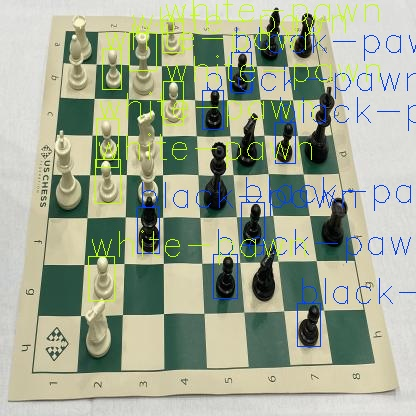

In [ ]:
# Run test for a random image using a chosen checkpoints and visualization the result
w = int(608)
!python models.py {num_classes} checkpoints/Yolov4_epoch25.pth {img_path} {w} {w} test/_classes.txt

from IPython.display import Image
Image('predictions.jpg')

In [ ]:
!pwd

/content/gdrive/My Drive/colab/pytorch-YOLOv4


In [ ]:
num_classes

12